In [2]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Preprocessing and Pipeline libraries
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
import pickle

print("\nLoading training data...")
# load training data
test_data = pd.read_csv("Data/peerLoanTraining.csv", engine='python', header=0)

# Separate out X and y
X_train = test_data.loc[:, test_data.columns != 'is_late']
y_train = test_data['is_late']

# load test data
test_data = pd.read_csv("Data/peerLoanTest.csv", engine='python', header=0)

# Separate out X and y
X_test = test_data.loc[:, test_data.columns != 'is_late']
y_test = test_data['is_late']

# Preprocessing Steps
numeric_features = ['loan_amnt', 
                    'int_rate', 'annual_inc', 'revol_util', 
                    'dti', 'delinq_2yrs'
                   ]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ])

categorical_features = ['purpose','grade', 'emp_length', 'home_ownership']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ]
    )

# Combine preprocessing with classifier
latePaymentsModel = make_pipeline(
    preprocess,
    RandomForestClassifier(random_state=42))

# Fit the pipeline to the training data (fit is for both the preprocessing and the classifier)
print("\nTraining model ...")
latePaymentsModel.fit(X_train, y_train)

# Save the trained model as a pickle file
print("\nSaving model ...")
file = open('models/latePaymentsModel.pkl', 'wb')
pickle.dump(latePaymentsModel, file)
file.close()




Loading training data...

Training model ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Saving model ...


In [3]:
# load the pickled model
print("\nLoading saved model to make example predictions...")
pickledModel = pickle.load(open('models/latePaymentsModel.pkl','rb'))

# Make a prediction for a likely on time payer
payOnTimePrediction = {
    'loan_amnt': [100],
    'int_rate': [0.02039],
    'purpose': ['credit_card'],
    'grade': ['A'],
    'annual_inc': [80000.00],
    'revol_util': [0.05],
    'emp_length': ['10+ years'],
    'dti': [1.46],
    'delinq_2yrs': [0],
    'home_ownership': ['RENT']
    }
payOnTimePredictionDf = pd.DataFrame.from_dict(payOnTimePrediction)

print("\nPredicting class probabilities for likely on-time payer:")
print(pickledModel.predict_proba(payOnTimePredictionDf))

# Prediction for a likely late payer
payLatePrediction = {
    'loan_amnt': [10000],
    'int_rate': [0.6],
    'purpose': ['credit_card'],
    'grade': ['D'],
    'annual_inc': [20000.00],
    'revol_util': [0.85],
    'emp_length': ['1 year'],
    'dti': [42.00],
    'delinq_2yrs': [4],
    'home_ownership': ['RENT']
    }
payLatePredictionDf = pd.DataFrame.from_dict(payLatePrediction)

print("\nPredicting class probabilities for a likely late payer:")
print(pickledModel.predict_proba(payLatePredictionDf))

# Predict class probabilities for a set of records using the test set
print("\nPredicting class probabilities for the test data set:")
print(pickledModel.predict_proba(X_test))

from sklearn.metrics import accuracy_score
print("Accuracy:\n%s" % accuracy_score(y_test, pickledModel.predict(X_test)))



Loading saved model to make example predictions...

Predicting class probabilities for likely on-time payer:
[[1. 0.]]

Predicting class probabilities for a likely late payer:
[[0.7 0.3]]

Predicting class probabilities for the test data set:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Accuracy:
0.9861172000584539


In [5]:
y_pred_proba = pickledModel.predict_proba(X_test)
y_pred_proba[:,1]

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
y_test_pred = np.where(y_pred_proba[:,1]>=0.2,1,0)

In [12]:
sum(y_test_pred)

324

In [7]:
sum(y_test)

95

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[6438,  310],
       [  81,   14]], dtype=int64)

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import *

In [20]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba[:,1])

In [21]:
fpr, tpr, thresholds

(array([0.00000000e+00, 7.40960285e-04, 2.37107291e-03, 1.20035566e-02,
        4.59395376e-02, 1.89834025e-01, 1.00000000e+00]),
 array([0.        , 0.01052632, 0.02105263, 0.02105263, 0.14736842,
        0.42105263, 1.        ]),
 array([1.5, 0.5, 0.4, 0.3, 0.2, 0.1, 0. ]))

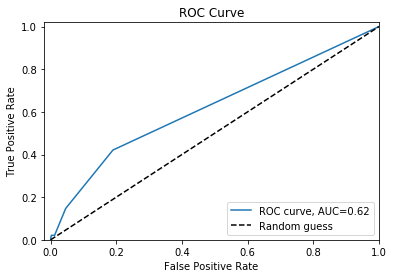

In [23]:
plt.plot(fpr, tpr, label='ROC curve'+', AUC='+str(round(roc_auc_score(y_test, y_pred_proba[:,1]).mean(),3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")